In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw9.ipynb")

# Homework 9: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: Thursday 4/15,  11:59 PM PST

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this homework, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this homework, you should feel comfortable with the following:

- Feature engineering with text data
- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset – the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the homework so that you are made aware.

## Disclaimer about `sns.distplot()`

This homework was designed for a slightly older version of seaborn, which does not support the new `displot` method taught in lecture. Instead, in this homework will occasionally call `distplot` (with a `t`). As you may have noticed in several of the previous assignments, use of the `distplot` function triggers a deprecation warning to notify the user that they should replace all deprecated functions with the updated version. Generally, warnings should not be suppressed but we will do so in this assignment to avoid cluttering.

See the seaborn documentation on [distributions](https://seaborn.pydata.org/tutorial/distributions.html) and [functions](https://seaborn.pydata.org/tutorial/function_overview.html) for more details.

In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Score Breakdown
Question | Points
--- | ---
1 | 2
2 | 3
3 | 2
4 | 2
5 | 2
6a | 1
6b | 1
6c | 2
6d | 2
6e | 1
6f | 3
Total | 21

# Part I - Initial Analysis

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [4]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Thu Apr 15 02:10:26 2021
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Thu Apr 15 02:10:27 2021
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


First, let's check if our data contains any missing values. We have filled in the cell below to print the number of NaN values in each column. If there are NaN values, we replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns will be replaced with empty strings). Finally, we print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [5]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


### Question 1

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [6]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



<!-- BEGIN QUESTION -->

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1
manual: True
points: 2
-->

The spam emails tend to have many htmls and phrases that are very vague yet affirmative such as "guaranteed", "more than enough" and words like "come in here and check it out", which is common in spam emails. 

<!-- END QUESTION -->



## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [7]:
# This creates a 90/10 train-validation split on our labeled data

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train a logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = [[1 if word in text else 0 for word in words] for text in texts]
    
    return indicator_array

In [9]:
words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

[[1, 0, 0], [1, 0, 1]]

In [10]:
grader.check("q2")

q2 passed!

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](images/training_conditional_proportions.png)

You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [11]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column."))
display(df.melt("type"))

> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


<!-- BEGIN QUESTION -->

### Question 3

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3
manual: True
format: image
points: 2
-->

Text(0.5, 1.0, 'Frequecy of Words in Spam/Ham Emails')

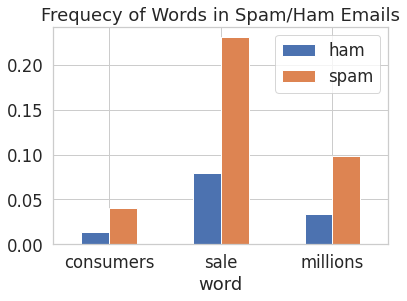

In [12]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
new = words_in_texts(['consumers','sale','millions'], train['email'])
train['new'] = new
first_entry_one_for_ham = np.count_nonzero([item[0] for item in train['new']])/len(train.loc[train['spam']==0]['id'])
second_entry_one_for_ham = np.count_nonzero([item[1] for item in train['new']])/len(train.loc[train['spam']==0]['id'])
third_entry_one_for_ham = np.count_nonzero([item[2] for item in train['new']])/len(train.loc[train['spam']==0]['id'])

first_entry_one_for_spam = np.count_nonzero([item[0] for item in train['new']])/len(train.loc[train['spam']==1]['id'])
second_entry_one_for_spam = np.count_nonzero([item[1] for item in train['new']])/len(train.loc[train['spam']==1]['id'])
third_entry_one_for_spam = np.count_nonzero([item[2] for item in train['new']])/len(train.loc[train['spam']==1]['id'])


plot_df = pd.DataFrame({
    'word': ['consumers','sale','millions'],
    'ham': [first_entry_one_for_ham, second_entry_one_for_ham, third_entry_one_for_ham],
    'spam': [first_entry_one_for_spam,second_entry_one_for_spam,third_entry_one_for_spam]
})
plot_df.head()
plot_df.set_index('word').plot.bar(rot=0)
plt.title('Frequecy of Words in Spam/Ham Emails')


<!-- END QUESTION -->



When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of only 0's and 1's). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [13]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = np.array(words_in_texts(some_words, train['email']))
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [14]:
grader.check("q4")

q4 passed!

### Question 5

Now that we have matrices, we can build a model with `scikit-learn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.75$

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True, solver='lbfgs')
model.fit(X_train,Y_train)

training_accuracy = np.mean(model.predict(X_train)==Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [16]:
grader.check("q5")

q5 passed!

## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The two graphics below may help you understand precision and recall visually:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (feel free to hard code your answers for this part):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [17]:
zero_predictor_fp = 0
zero_predictor_fn = np.count_nonzero(Y_train)
zero_predictor_fp, zero_predictor_fn

(0, 1918)

In [18]:
grader.check("q6a")

q6a passed!

### Question 6b

What is the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [19]:
zero_predictor_acc = (len(Y_train)-zero_predictor_fn)/len(Y_train)
zero_predictor_recall = 0
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0)

In [20]:
grader.check("q6b")

q6b passed!

<!-- BEGIN QUESTION -->

### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

The classifier from 6a always predicts 0, so it would never give any FP and would likely give many FNs, thus the recall would be zero. The accuaracy was okay since the majority of the emails are ham, so by predicting all of them to be ham, we are right about 75 percent of the time. But this does not show that the zero predictor is a good classifier at all.

<!-- END QUESTION -->

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [21]:
Y_predict = model.predict(X_train)
TP = np.sum((Y_train == Y_predict) & (Y_train == 1))
FP = np.sum((Y_train != Y_predict) & (Y_train == 0))
FN = np.sum((Y_train != Y_predict) & (Y_train == 1))
TN = np.sum((Y_train == Y_predict) & (Y_train == 0))

In [22]:
logistic_predictor_precision = TP/(TP + FP)
logistic_predictor_recall = TP/(TP + FN)
logistic_predictor_far = FP/(FP + TN)


In [23]:
grader.check("q6d")

q6d passed!

<!-- BEGIN QUESTION -->

### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->

There are more false positives and fewer false negatives when using the logistic regression.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

1. Our logistic regression classifier got 75.76% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->

1. The logistic regression classifier gives a higher prediction accuracy than the zero predictor, which gives a 74.47% prediction accuracy.
2. Words like "bank","memo","private" are really common words, which may also apprear ofter in ham emails, making the classifier less desirable.
3. Probably the zero predictor, even though the zero predictor just assigns every email to be the ham, which is kind of pointless. However, it is still better than the logistic regression classifier, which gives many FPs, meaning I may miss many potentially important emails. For emails, I want as few FPs as possible and FNs would hurt me less, so I would go with the zero predictor.

<!-- END QUESTION -->



## Congratulations! You have completed homework 9. 

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [24]:
grader.check_all()

q2 passed!

q4 passed!

q5 passed!

q6a passed!

q6b passed!

q6d passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()